# Appendix: Expressivity and Depth

Recall that a (fully-connected) ReLU neuron divides its input space into two (i.e. inactive and active regions of the ReLU neuron). If we have $k$ neurons in a layer $f$, then $f(\boldsymbol{\mathsf{x}})$ is a $k$-tuple which corresponds to the **activation pattern** (active / inactive) for the $k$ ReLU neurons. 
The resulting activation pattern can be thought of as a signature of the layer output for that region. This results in a *carving* of the input space that is suggested by the plot below:

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "svg"

RANDOM_SEED = 420
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

In [2]:
from tqdm.notebook import tqdm
from sklearn.datasets import make_moons

x, y = make_moons(1500, noise=0.05, random_state=RANDOM_SEED)
x = torch.tensor(x).float()
y = torch.tensor(y)

model = nn.Sequential(
    nn.Linear(2, 5), nn.ReLU(),
    nn.Linear(5, 5), nn.ReLU(),
    nn.Linear(5, 5), nn.ReLU(),
    nn.Linear(5, 2)
)

optim = torch.optim.Adam(model.parameters(), lr=0.003)

history = []
for step in tqdm(range(1500)):
    s = model(x)
    loss = F.cross_entropy(s, y)
    loss.backward()
    optim.step()
    optim.zero_grad()
    history.append(loss.item())

  0%|          | 0/1500 [00:00<?, ?it/s]

Final loss: 1.30e-04


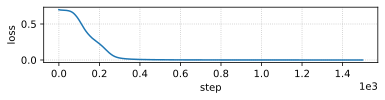

In [3]:
print(f"Final loss: {history[-1]:.2e}")
plt.figure(figsize=(6, 1))
plt.plot(history)
plt.xlabel("step")
plt.grid(linestyle="dotted", alpha=0.8)
plt.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
plt.ylabel("loss");

In [4]:
from matplotlib.colors import LinearSegmentedColormap

# Define your custom colormap
colors = ["C0", "C1"]
n_bins = 100
cm = LinearSegmentedColormap.from_list(name="", colors=colors, N=n_bins)

# Create a grid of points
N = 100
LIMIT = 3
u = np.linspace(-LIMIT, LIMIT, N)
v = np.linspace(-LIMIT, LIMIT, N)
X, Y = np.meshgrid(u, v)

# Calculate function values for each point on the grid
Z = np.zeros_like(X)
for i in range(N):
    for j in range(N):
        inp = torch.tensor([[float(X[i, j]), float(Y[i, j])]])
        out = F.softmax(model(inp), dim=1)
        Z[i, j] = out[0][1]

# Create a color plot using the custom colormap
plt.pcolormesh(X, Y, Z, shading='auto', cmap=cm)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

x0 = x[y == 0]
x1 = x[y == 1]
plt.scatter(x0[:, 0], x0[:, 1], s=10.0, label=0, color="C0", edgecolor="black")
plt.scatter(x1[:, 0], x1[:, 1], s=10.0, label=1, color="C1", edgecolor="black")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.legend(loc="lower right")

plt.xlim(-(LIMIT - 0.3), (LIMIT - 0.3))
plt.ylim(-(LIMIT - 0.3), (LIMIT - 0.3))
plt.show();

Fig. *To model the training data, ReLU neurons collectively carve the input space.*

## Effect of layer width

Clearly, as we increase the neurons in the layer, we get more convex subsets that partition the input space. The exact upper bound can be calculated as follows (i.e. when the hyperplanes maximally partition the space). Let $r(k, d)$ be the maximal number of regions generated by $k$ hyperplanes in $\mathbb{R}^d.$ It turns out that

$$r(k, d) \leq \sum_{i=0}^d\binom{k}{i}$$

To prove this, we assume that a new hyperplane $H$ can intersect all
hyperplanes existing $k - 1$ hyperplanes. Then, $r(k - 1, d)$ is increased by the number of regions generated within $H$, i.e. $r(k - 1, d- 1).$ Thus,

$$r(k, d) = r(k - 1, d) + r(k - 1, d - 1).$$

This can be seen in {numref}`01-polytopes`. For the base steps, we clearly have $r(1, 2) = 2$ and $r(1, 1) = 2.$ For example, $r(2, 2) = 4$ which makes sense (two hyperplanes maximally divide $\mathbb{R}^2$ into 4 disjoint subsets). Proving the inductive step for $k, d \geq 2$:

$$\begin{aligned}
r(k - 1, d) + r(k - 1, d - 1) 
&\leq \sum_{i=0}^d\binom{k-1}{i} + \sum_{j=0}^{d-1}\binom{k-1}{j} \\ 
&= \binom{k-1}{0} + \sum_{i=0}^{d-1}\binom{k-1}{i + 1} + \sum_{j=0}^{d-1}\binom{k-1}{j} \\
&= \binom{k-1}{0} + \sum_{j=0}^{d-1}\left[\binom{k-1}{j + 1} + \binom{k-1}
{j}\right] \\
&= \binom{k-1}{0} + \sum_{j=0}^{d-1}\binom{k}{j + 1} \quad\quad \text{Pascal's Identity} \\
&= \binom{k}{0} + \sum_{j=1}^{d}\binom{k}{j} \quad\quad\quad\quad \text{i.e.} \binom{k-1}{0} = \binom{k}{0} = 1\\
&= \sum_{j=0}^{d}\binom{k}{j}. \\
\end{aligned}
$$

Recall $\binom{k}{0}$ is 1 (i.e. the empty set). Note that $\binom{k}{d} = \frac{1}{d!}k(k-1)\ldots(k-d+1)$, so that $r(k, d)$ is a polynomial in $k$ of degree $d$. It turns out that $r(k, d) \leq k^d.$ 
This makes sense by counting activation signatures $k^d$ for each of the $d$ input dimension with $k$ hyperplanes. In reality, a hyperplane does not cut across all regions, so this is not a tight bound.

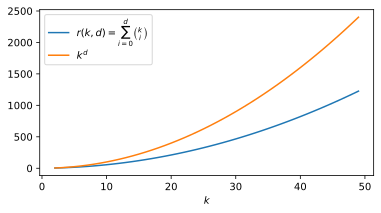

In [8]:
from math import comb
import matplotlib.pyplot as plt

K = list(range(2, 50))
d = 2
plt.figure(figsize=(6, 3))
plt.plot(K, [sum(comb(k, i) for i in range(0, d + 1)) for k in K], label=r"$r(k, d) = \sum_{i=0}^d\binom{k}{i}$")
plt.plot(K, [k ** d for k in K], label=r"$k^d$")
plt.xlabel("$k$")
plt.legend();

```{figure} ../../../img/nn/01-polytopes.png
---
name: 01-polytopes
width: 500px
align: center
---
Demonstrating the counting method used by partitioning $\mathbb{R}^2$ with 4 lines.
Here $r(4, 2)$ is computed in two ways as the sum $r(3, 2) + r(3, 1)$ and the sum $\binom{4}{0} + \binom{4}{1} + \binom{4}{2}.$
```

## Effect of network depth

In the previous section, we found that $k$ neurons partition the input space $\mathbb{R}^d$ into $O(k^d)$ convex subsets. Then, these subspaces are further subdivided by neurons in the next layer. This is the benefit of depth: it allows the network to further carve its input space combinatorially with each layer in the network. It follows that a deep network with $k_1, \ldots, k_L$ neurons will have an input space carving containing $O({k_1}^d \cdot \ldots \cdot {k_L}^d)$ elements. For simplicity, assume the network has fixed width $k$ and depth $L$, then the input space $\mathbb{R}^d$ is carved into $O(k^{dL})$ subsets. Thus, depth contributes **exponentially** to network expressivity, while width contributes **polynomially**.[^1]

[^1]: Care must be taken to not bottleneck the network since the partitioning occurs hierarchically. For example, if we use a single ReLU at layer 1, so that $k = 1$, it can be shown that any further partitioning only occurs along one dimension (determined the weight vector of the initial layer), effectively reducing $\mathbb{R}^d$ to one dimension. 

{numref}`relu-polytopes` demonstrates the carving process as the network becomes deep. Recall that the pre-image of disjoint sets under a continuous function are disjoint. 
Hence, the pre-image of the inputs to Layer 2 can be obtained as a further partitioning of the initial partition consisting of 4 subsets in layer 1 (e.g. `ia` is partitioned into `iaai` and `iaii`). 
Note that general topological features are preserved in the pre-image of each partioning of the output space in terms of activation patterns. For example, the region `(a, i)` in Layer 2 (colored yellow), corresponds to the colored region in layer 1 (bottom left), but with the point $(0, 0)$ expanded to an entire region, surrounded by some of the blue and yellow regions.

Note that all operations are piecewise linear, so that points in the output space (of any layer), that lie on the boundary of a hyperplane in that space, have a pre-image that form a linear surface in the input space $\mathbb{R}^d$. Bend lines occur when the boundary transitions to another activation pattern. For example, let us calculate the part of the $y$-axis that is in the active region of $H_3$ in Layer 2. Let $H_3$ be determined by $(\boldsymbol{\mathsf{w}}_3, {b}_3)$, then the said region corresponds to ${\mathsf{w}}_{32} (\boldsymbol{\mathsf{w}}_2 \cdot \boldsymbol{\mathsf{x}}) + b_3 = 0$ which corresponds to a hyperplane parallel to $H_2.$ As $H_3$ transitions to the `aa` region, we get a different activation pattern ${\mathsf{w}}_{32} (\boldsymbol{\mathsf{w}}_2 \cdot \boldsymbol{\mathsf{x}} + b_2) + {\mathsf{w}}_{31} (\boldsymbol{\mathsf{w}}_1 \cdot \boldsymbol{\mathsf{x}} + b_1) + b_3 = 0$ which is still a linear surface in $\mathbb{R}^d.$ Note that this is continuous at the bend point where $\boldsymbol{\mathsf{w}}_1 \cdot \boldsymbol{\mathsf{x}} + b_1 \to 0.$


```{figure} ../../../img/nn/relu-polytopes.png
---
name: relu-polytopes
width: 800px
align: center
---
Carving the input space with 3 layers each with 2 neurons. The top part shows the activation patterns generated by the ReLU neurons in that layer. This corresponds to a coloring of the input space. 
A yellow coloring of an input region refers to an activation with the first neuron in the layer, and blue likewise refers to an activation of the second neuron. Finally, green is when both neurons are activated, and red when no neurons are. These coloring of an input region in a bottom figure determine the part of the output space (next upper right figure) where it is mapped.
```

The new coloring is reflected based on the activation pattern in that layer. Finally, in Layer 3, we see the final activation pattern for each input region. Note that the inputs to a layer $\ell$ is given by $f^{\ell-1} \circ \ldots \circ f^0 (\boldsymbol{\mathsf{X}})$ where $f^0(\boldsymbol{\mathsf{X}}) = \boldsymbol{\mathsf{X}}.$ This sequence is shown on the top part of the figure, while the bottom figures show the evolution of the input space partitioning. The final partitioning indicates how the model will predict on its inputs. Note that the actual prediction will be based on a complex interaction of the weights and the actual activation values. So while we can't read off the actual prediction from the carving graph, a more complex model will generally have more partitions.

**Example.** Plotting actual activation patterns for the above trained model:

In [6]:
N = 50
LIMIT = 3
u = np.linspace(-LIMIT, LIMIT, N)
v = np.linspace(-LIMIT, LIMIT, N)
X, Y = np.meshgrid(u, v)
X = X.reshape(-1)
Y = Y.reshape(-1)

input_space = torch.stack([torch.tensor(X), torch.tensor(Y)], dim=1).float()
input_space.shape

torch.Size([2500, 2])

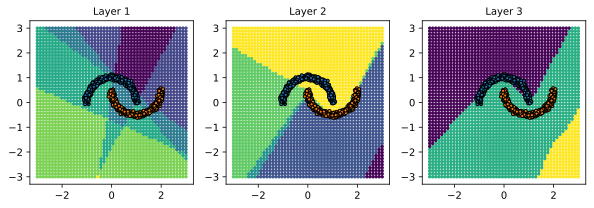

In [7]:
def plot_pattern(ax, out, weights=(1, 1, 1, 1, 1,), title=""):
    w = weights
    Z0 = out[:, 0]
    Z1 = out[:, 1]
    Z2 = out[:, 2]
    Z3 = out[:, 3]
    Z4 = out[:, 4]
    Z = w[0] * (Z0 > 0).int() + w[1] * (Z1 > 0).int() + w[2] * (Z2 > 0).int() + w[3] * (Z3 > 0).int() + w[4] * (Z4 > 0).int()

    xx = input_space
    x0 = x[y == 0]
    x1 = x[y == 1]
    ax.scatter(x0[:, 0], x0[:, 1], s=10.0, label=0, color="C0", edgecolor="black", zorder=2)
    ax.scatter(x1[:, 0], x1[:, 1], s=10.0, label=1, color="C1", edgecolor="black", zorder=2)
    ax.scatter(xx[:, 0], xx[:, 1], c=Z.detach().cpu().numpy(), s=6)
    ax.set_aspect("equal")
    ax.set_title(title, fontsize=10)


fig, ax = plt.subplots(1, 3, figsize=(10, 4))
out0 = F.relu(model[0](input_space))
out1 = F.relu(model[2](out0))
out2 = F.relu(model[4](out1))
plot_pattern(ax[0], out0, title="Layer 1")
plot_pattern(ax[1], out1, title="Layer 2")
plot_pattern(ax[2], out2, weights=model[6].weight[1], title="Layer 3")

Note that regions for Layer 3 are colored by its weight for class 1, and with each activation set to 1.